## 01. GAN
- 생성적 적대 신경망
- 주어진 자료를 통해 그럴듯한 가짜를 만들어 낸다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [3]:
## MNIST 데이터 셋 불러오기, 정규화

def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    print("데이터 값의 범위 : ", np.min(x_train), np.max(x_train) )
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [4]:
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
데이터 값의 범위 :  -1.0 1.0
(60000, 784)


In [5]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [6]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [9]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)    # 레이어를 객체로 그룹화
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

# g = create_generator()     # 생성자
# d = create_discriminator()  # 판별자

gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [10]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [11]:
def training(epochs=1, batch_size=128):
    
    # 데이터 불러오기(Loading the data)
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Noise를 이용하여 MNIST이미지 만들기( Generate fake MNIST images from noised input )
            generated_images = generator.predict(noise)
            
            # Get a random set of real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            # Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            # Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            # Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            # training  the GAN by alternating the training of the Discriminator 
            # and training the chained GAN model with Discriminator's weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)

데이터 값의 범위 :  -1.0 1.0
Epoch 1


100%|██████████| 256/256 [00:21<00:00, 11.81it/s]


Epoch 2


100%|██████████| 256/256 [00:17<00:00, 14.31it/s]


Epoch 3


100%|██████████| 256/256 [00:18<00:00, 13.96it/s]


Epoch 4


100%|██████████| 256/256 [00:18<00:00, 13.59it/s]


Epoch 5


100%|██████████| 256/256 [00:17<00:00, 14.30it/s]


Epoch 6


100%|██████████| 256/256 [00:18<00:00, 14.06it/s]


Epoch 7


100%|██████████| 256/256 [00:17<00:00, 14.28it/s]


Epoch 8


100%|██████████| 256/256 [00:18<00:00, 14.12it/s]


Epoch 9


100%|██████████| 256/256 [00:17<00:00, 14.23it/s]


Epoch 10


100%|██████████| 256/256 [00:18<00:00, 13.95it/s]


Epoch 11


100%|██████████| 256/256 [00:17<00:00, 14.25it/s]


Epoch 12


100%|██████████| 256/256 [00:18<00:00, 14.00it/s]


Epoch 13


100%|██████████| 256/256 [00:17<00:00, 14.42it/s]


Epoch 14


100%|██████████| 256/256 [00:18<00:00, 14.08it/s]


Epoch 15


100%|██████████| 256/256 [00:18<00:00, 14.13it/s]


Epoch 16


100%|██████████| 256/256 [00:18<00:00, 14.07it/s]


Epoch 17


100%|██████████| 256/256 [00:17<00:00, 14.33it/s]


Epoch 18


100%|██████████| 256/256 [00:17<00:00, 14.40it/s]


Epoch 19


100%|██████████| 256/256 [00:17<00:00, 14.36it/s]


Epoch 20


100%|██████████| 256/256 [00:18<00:00, 13.83it/s]


Epoch 21


100%|██████████| 256/256 [00:18<00:00, 13.69it/s]


Epoch 22


100%|██████████| 256/256 [00:17<00:00, 14.32it/s]


Epoch 23


100%|██████████| 256/256 [00:17<00:00, 14.42it/s]


Epoch 24


100%|██████████| 256/256 [00:18<00:00, 13.99it/s]


Epoch 25


100%|██████████| 256/256 [00:18<00:00, 13.93it/s]


Epoch 26


100%|██████████| 256/256 [00:17<00:00, 14.25it/s]


Epoch 27


100%|██████████| 256/256 [00:18<00:00, 14.12it/s]


Epoch 28


100%|██████████| 256/256 [00:18<00:00, 14.16it/s]


Epoch 29


100%|██████████| 256/256 [00:18<00:00, 13.77it/s]


Epoch 30


100%|██████████| 256/256 [00:18<00:00, 14.05it/s]


Epoch 31


100%|██████████| 256/256 [00:18<00:00, 13.91it/s]


Epoch 32


100%|██████████| 256/256 [00:18<00:00, 14.22it/s]


Epoch 33


100%|██████████| 256/256 [00:18<00:00, 14.02it/s]


Epoch 34


100%|██████████| 256/256 [00:17<00:00, 14.26it/s]


Epoch 35


100%|██████████| 256/256 [00:18<00:00, 14.18it/s]


Epoch 36


100%|██████████| 256/256 [00:17<00:00, 14.24it/s]


Epoch 37


100%|██████████| 256/256 [00:17<00:00, 14.24it/s]


Epoch 38


100%|██████████| 256/256 [00:18<00:00, 13.69it/s]


Epoch 39


100%|██████████| 256/256 [00:17<00:00, 14.25it/s]


Epoch 40


100%|██████████| 256/256 [00:18<00:00, 14.10it/s]


Epoch 41


100%|██████████| 256/256 [00:18<00:00, 14.00it/s]


Epoch 42


100%|██████████| 256/256 [00:18<00:00, 14.04it/s]


Epoch 43


100%|██████████| 256/256 [00:17<00:00, 14.34it/s]


Epoch 44


100%|██████████| 256/256 [00:17<00:00, 14.35it/s]


Epoch 45


100%|██████████| 256/256 [00:17<00:00, 14.33it/s]


Epoch 46


100%|██████████| 256/256 [00:18<00:00, 14.03it/s]


Epoch 47


100%|██████████| 256/256 [00:18<00:00, 13.83it/s]


Epoch 48


100%|██████████| 256/256 [00:18<00:00, 14.16it/s]


Epoch 49


100%|██████████| 256/256 [00:18<00:00, 14.01it/s]


Epoch 50


100%|██████████| 256/256 [00:17<00:00, 14.30it/s]


Epoch 51


100%|██████████| 256/256 [00:18<00:00, 14.00it/s]


Epoch 52


100%|██████████| 256/256 [00:18<00:00, 14.19it/s]


Epoch 53


100%|██████████| 256/256 [00:17<00:00, 14.25it/s]


Epoch 54


100%|██████████| 256/256 [00:18<00:00, 13.86it/s]


Epoch 55


100%|██████████| 256/256 [00:18<00:00, 14.19it/s]


Epoch 56


100%|██████████| 256/256 [00:18<00:00, 13.91it/s]


Epoch 57


100%|██████████| 256/256 [00:17<00:00, 14.26it/s]


Epoch 58


100%|██████████| 256/256 [00:17<00:00, 14.44it/s]


Epoch 59


100%|██████████| 256/256 [00:17<00:00, 14.37it/s]


Epoch 60


100%|██████████| 256/256 [00:18<00:00, 13.95it/s]


Epoch 61


100%|██████████| 256/256 [00:18<00:00, 13.97it/s]


Epoch 62


100%|██████████| 256/256 [00:18<00:00, 14.19it/s]


Epoch 63


100%|██████████| 256/256 [00:17<00:00, 14.36it/s]


Epoch 64


100%|██████████| 256/256 [00:17<00:00, 14.34it/s]


Epoch 65


100%|██████████| 256/256 [00:18<00:00, 13.52it/s]


Epoch 66


100%|██████████| 256/256 [00:18<00:00, 14.21it/s]


Epoch 67


100%|██████████| 256/256 [00:17<00:00, 14.24it/s]


Epoch 68


100%|██████████| 256/256 [00:17<00:00, 14.34it/s]


Epoch 69


100%|██████████| 256/256 [00:18<00:00, 14.00it/s]


Epoch 70


100%|██████████| 256/256 [00:17<00:00, 14.39it/s]


Epoch 71


100%|██████████| 256/256 [00:17<00:00, 14.32it/s]


Epoch 72


100%|██████████| 256/256 [00:17<00:00, 14.36it/s]


Epoch 73


100%|██████████| 256/256 [00:17<00:00, 14.30it/s]


Epoch 74


100%|██████████| 256/256 [00:18<00:00, 13.59it/s]


Epoch 75


100%|██████████| 256/256 [00:18<00:00, 14.17it/s]


Epoch 76


100%|██████████| 256/256 [00:17<00:00, 14.38it/s]


Epoch 77


100%|██████████| 256/256 [00:17<00:00, 14.36it/s]


Epoch 78


100%|██████████| 256/256 [00:18<00:00, 14.21it/s]


Epoch 79


100%|██████████| 256/256 [00:17<00:00, 14.38it/s]


Epoch 80


100%|██████████| 256/256 [00:17<00:00, 14.41it/s]


Epoch 81


100%|██████████| 256/256 [00:18<00:00, 14.08it/s]


Epoch 82


100%|██████████| 256/256 [00:17<00:00, 14.35it/s]


Epoch 83


100%|██████████| 256/256 [00:18<00:00, 14.16it/s]


Epoch 84


100%|██████████| 256/256 [00:17<00:00, 14.30it/s]


Epoch 85


100%|██████████| 256/256 [00:17<00:00, 14.27it/s]


Epoch 86


100%|██████████| 256/256 [00:17<00:00, 14.44it/s]


Epoch 87


100%|██████████| 256/256 [00:18<00:00, 13.67it/s]


Epoch 88


100%|██████████| 256/256 [00:17<00:00, 14.28it/s]


Epoch 89


100%|██████████| 256/256 [00:18<00:00, 14.22it/s]


Epoch 90


100%|██████████| 256/256 [00:17<00:00, 14.28it/s]


Epoch 91


100%|██████████| 256/256 [00:17<00:00, 14.44it/s]


Epoch 92


100%|██████████| 256/256 [00:17<00:00, 14.41it/s]


Epoch 93


100%|██████████| 256/256 [00:18<00:00, 14.05it/s]


Epoch 94


100%|██████████| 256/256 [00:17<00:00, 14.28it/s]


Epoch 95


100%|██████████| 256/256 [00:17<00:00, 14.39it/s]


Epoch 96


100%|██████████| 256/256 [00:18<00:00, 14.19it/s]


Epoch 97


100%|██████████| 256/256 [00:17<00:00, 14.40it/s]


Epoch 98


100%|██████████| 256/256 [00:18<00:00, 13.71it/s]


Epoch 99


100%|██████████| 256/256 [00:17<00:00, 14.26it/s]


Epoch 100


100%|██████████| 256/256 [00:17<00:00, 14.38it/s]


Epoch 101


100%|██████████| 256/256 [00:18<00:00, 14.14it/s]


Epoch 102


100%|██████████| 256/256 [00:18<00:00, 14.01it/s]


Epoch 103


100%|██████████| 256/256 [00:18<00:00, 13.87it/s]


Epoch 104


100%|██████████| 256/256 [00:17<00:00, 14.42it/s]


Epoch 105


100%|██████████| 256/256 [00:18<00:00, 13.86it/s]


Epoch 106


100%|██████████| 256/256 [00:17<00:00, 14.23it/s]


Epoch 107


100%|██████████| 256/256 [00:17<00:00, 14.23it/s]


Epoch 108


100%|██████████| 256/256 [00:17<00:00, 14.26it/s]


Epoch 109


100%|██████████| 256/256 [00:17<00:00, 14.55it/s]


Epoch 110


100%|██████████| 256/256 [00:17<00:00, 14.45it/s]


Epoch 111


100%|██████████| 256/256 [00:18<00:00, 14.00it/s]


Epoch 112


100%|██████████| 256/256 [00:17<00:00, 14.40it/s]


Epoch 113


100%|██████████| 256/256 [00:17<00:00, 14.28it/s]


Epoch 114


100%|██████████| 256/256 [00:17<00:00, 14.26it/s]


Epoch 115


100%|██████████| 256/256 [00:18<00:00, 13.79it/s]


Epoch 116


100%|██████████| 256/256 [00:17<00:00, 14.36it/s]


Epoch 117


100%|██████████| 256/256 [00:17<00:00, 14.40it/s]


Epoch 118


100%|██████████| 256/256 [00:17<00:00, 14.44it/s]


Epoch 119


100%|██████████| 256/256 [00:17<00:00, 14.49it/s]


Epoch 120


100%|██████████| 256/256 [00:18<00:00, 13.96it/s]


Epoch 121


100%|██████████| 256/256 [00:18<00:00, 13.98it/s]


Epoch 122


100%|██████████| 256/256 [00:18<00:00, 13.63it/s]


Epoch 123


100%|██████████| 256/256 [00:18<00:00, 14.00it/s]


Epoch 124


100%|██████████| 256/256 [00:18<00:00, 14.21it/s]


Epoch 125


100%|██████████| 256/256 [00:17<00:00, 14.34it/s]


Epoch 126


100%|██████████| 256/256 [00:17<00:00, 14.23it/s]


Epoch 127


100%|██████████| 256/256 [00:17<00:00, 14.26it/s]


Epoch 128


100%|██████████| 256/256 [00:18<00:00, 14.15it/s]


Epoch 129


100%|██████████| 256/256 [00:18<00:00, 14.05it/s]


Epoch 130


100%|██████████| 256/256 [00:18<00:00, 14.19it/s]


Epoch 131


100%|██████████| 256/256 [00:17<00:00, 14.43it/s]


Epoch 132


100%|██████████| 256/256 [00:18<00:00, 14.22it/s]


Epoch 133


100%|██████████| 256/256 [00:17<00:00, 14.22it/s]


Epoch 134


100%|██████████| 256/256 [00:18<00:00, 13.93it/s]


Epoch 135


100%|██████████| 256/256 [00:19<00:00, 13.26it/s]


Epoch 136


100%|██████████| 256/256 [00:18<00:00, 14.00it/s]


Epoch 137


100%|██████████| 256/256 [00:18<00:00, 14.09it/s]


Epoch 138


100%|██████████| 256/256 [00:18<00:00, 13.98it/s]


Epoch 139


100%|██████████| 256/256 [00:18<00:00, 14.19it/s]


Epoch 140


100%|██████████| 256/256 [00:17<00:00, 14.33it/s]


Epoch 141


100%|██████████| 256/256 [00:18<00:00, 13.67it/s]


Epoch 142


100%|██████████| 256/256 [00:17<00:00, 14.25it/s]


Epoch 143


100%|██████████| 256/256 [00:18<00:00, 13.63it/s]


Epoch 144


100%|██████████| 256/256 [00:18<00:00, 14.19it/s]


Epoch 145


100%|██████████| 256/256 [00:18<00:00, 14.20it/s]


Epoch 146


100%|██████████| 256/256 [00:18<00:00, 14.01it/s]


Epoch 147


100%|██████████| 256/256 [00:18<00:00, 14.22it/s]


Epoch 148


100%|██████████| 256/256 [00:17<00:00, 14.37it/s]


Epoch 149


100%|██████████| 256/256 [00:17<00:00, 14.24it/s]


Epoch 150


100%|██████████| 256/256 [00:18<00:00, 14.09it/s]


Epoch 151


100%|██████████| 256/256 [00:17<00:00, 14.27it/s]


Epoch 152


100%|██████████| 256/256 [00:17<00:00, 14.38it/s]


Epoch 153


100%|██████████| 256/256 [00:17<00:00, 14.52it/s]


Epoch 154


100%|██████████| 256/256 [00:17<00:00, 14.24it/s]


Epoch 155


100%|██████████| 256/256 [00:18<00:00, 13.90it/s]


Epoch 156


100%|██████████| 256/256 [00:18<00:00, 13.56it/s]


Epoch 157


100%|██████████| 256/256 [00:18<00:00, 13.93it/s]


Epoch 158


100%|██████████| 256/256 [00:19<00:00, 12.95it/s]


Epoch 159


100%|██████████| 256/256 [00:18<00:00, 13.55it/s]


Epoch 160


100%|██████████| 256/256 [00:19<00:00, 13.39it/s]


Epoch 161


100%|██████████| 256/256 [00:18<00:00, 13.81it/s]


Epoch 162


100%|██████████| 256/256 [00:18<00:00, 13.85it/s]


Epoch 163


100%|██████████| 256/256 [00:18<00:00, 13.80it/s]


Epoch 164


100%|██████████| 256/256 [00:18<00:00, 13.86it/s]


Epoch 165


100%|██████████| 256/256 [00:17<00:00, 14.24it/s]


Epoch 166


100%|██████████| 256/256 [00:17<00:00, 14.32it/s]


Epoch 167


100%|██████████| 256/256 [00:18<00:00, 14.17it/s]


Epoch 168


100%|██████████| 256/256 [00:19<00:00, 13.39it/s]


Epoch 169


100%|██████████| 256/256 [00:18<00:00, 14.21it/s]


Epoch 170


100%|██████████| 256/256 [00:17<00:00, 14.27it/s]


Epoch 171


100%|██████████| 256/256 [00:17<00:00, 14.25it/s]


Epoch 172


100%|██████████| 256/256 [00:17<00:00, 14.29it/s]


Epoch 173


100%|██████████| 256/256 [00:18<00:00, 14.11it/s]


Epoch 174


100%|██████████| 256/256 [00:17<00:00, 14.27it/s]


Epoch 175


100%|██████████| 256/256 [00:17<00:00, 14.31it/s]


Epoch 176


100%|██████████| 256/256 [00:17<00:00, 14.32it/s]


Epoch 177


100%|██████████| 256/256 [00:18<00:00, 14.12it/s]


Epoch 178


100%|██████████| 256/256 [00:17<00:00, 14.30it/s]


Epoch 179


100%|██████████| 256/256 [00:17<00:00, 14.26it/s]


Epoch 180


100%|██████████| 256/256 [00:18<00:00, 14.01it/s]


Epoch 181


100%|██████████| 256/256 [00:18<00:00, 14.17it/s]


Epoch 182


100%|██████████| 256/256 [00:18<00:00, 13.94it/s]


Epoch 183


100%|██████████| 256/256 [00:18<00:00, 14.11it/s]


Epoch 184


100%|██████████| 256/256 [00:17<00:00, 14.33it/s]


Epoch 185


100%|██████████| 256/256 [00:17<00:00, 14.35it/s]


Epoch 186


100%|██████████| 256/256 [00:18<00:00, 13.99it/s]


Epoch 187


100%|██████████| 256/256 [00:17<00:00, 14.25it/s]


Epoch 188


100%|██████████| 256/256 [00:18<00:00, 14.21it/s]


Epoch 189


100%|██████████| 256/256 [00:17<00:00, 14.41it/s]


Epoch 190


100%|██████████| 256/256 [00:17<00:00, 14.36it/s]


Epoch 191


100%|██████████| 256/256 [00:18<00:00, 14.12it/s]


Epoch 192


100%|██████████| 256/256 [00:18<00:00, 13.97it/s]


Epoch 193


100%|██████████| 256/256 [00:17<00:00, 14.40it/s]


Epoch 194


100%|██████████| 256/256 [00:17<00:00, 14.40it/s]


Epoch 195


100%|██████████| 256/256 [00:18<00:00, 14.11it/s]


Epoch 196


100%|██████████| 256/256 [00:19<00:00, 13.25it/s]


Epoch 197


100%|██████████| 256/256 [00:17<00:00, 14.27it/s]


Epoch 198


100%|██████████| 256/256 [00:17<00:00, 14.30it/s]


Epoch 199


100%|██████████| 256/256 [00:17<00:00, 14.31it/s]


Epoch 200


100%|██████████| 256/256 [00:18<00:00, 13.98it/s]


CPU times: user 57min, sys: 3min 26s, total: 1h 27s
Wall time: 1h 52s


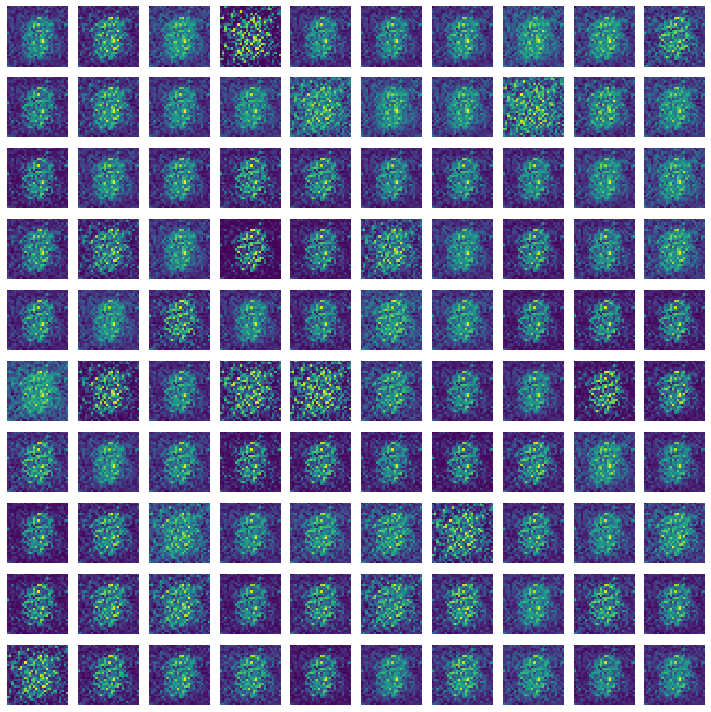

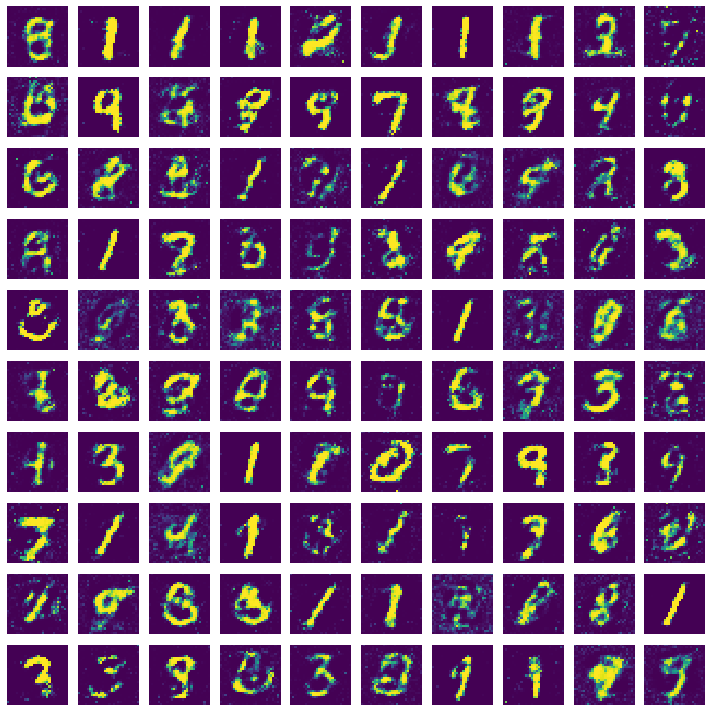

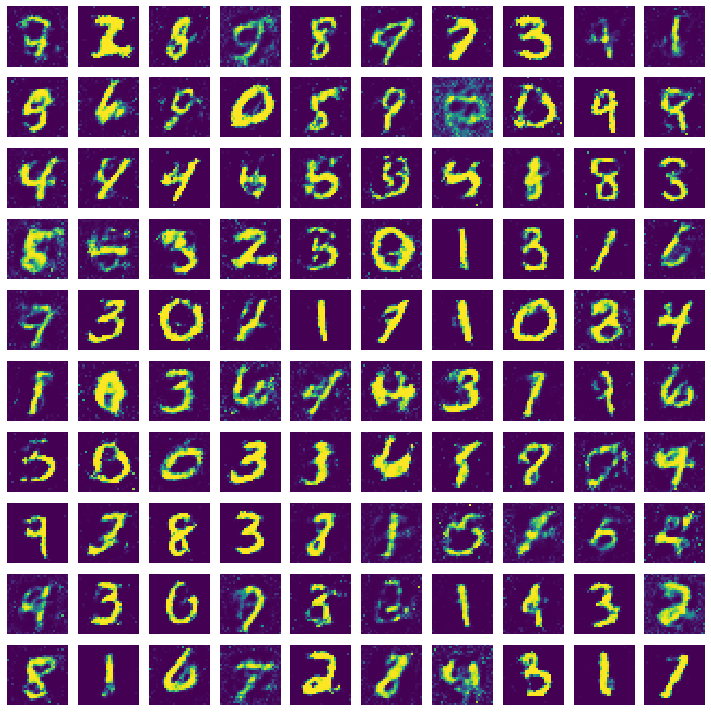

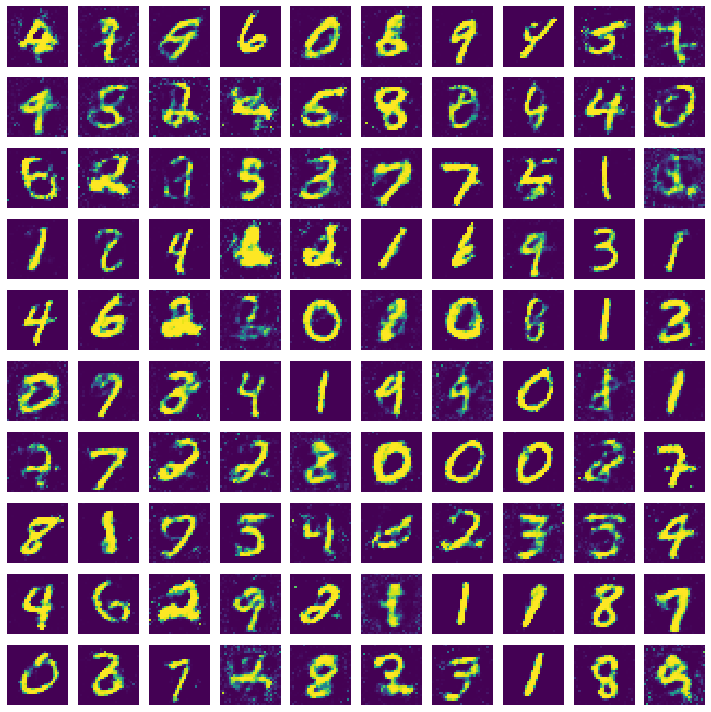

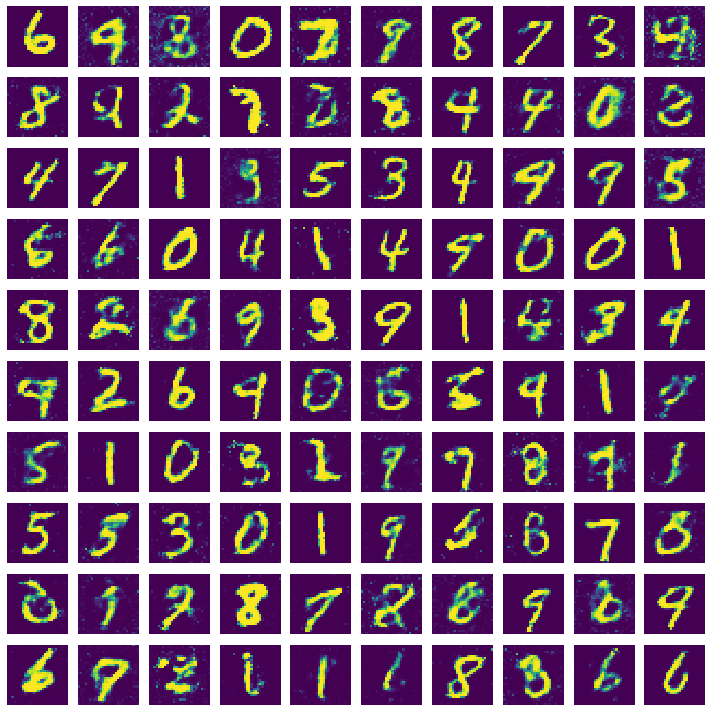

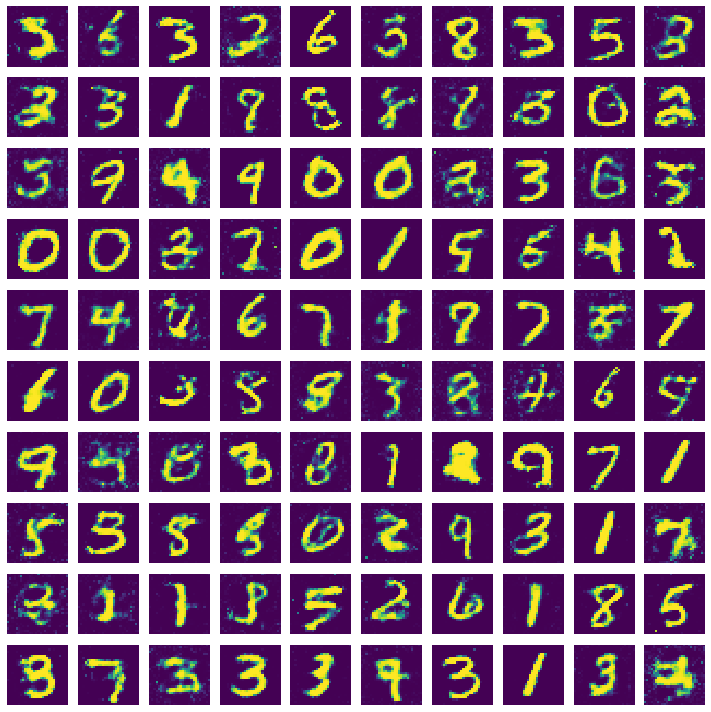

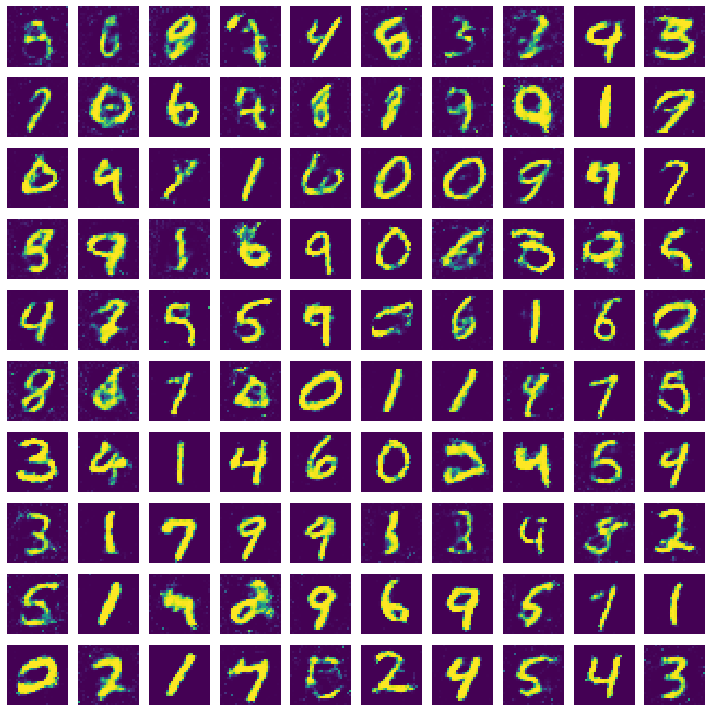

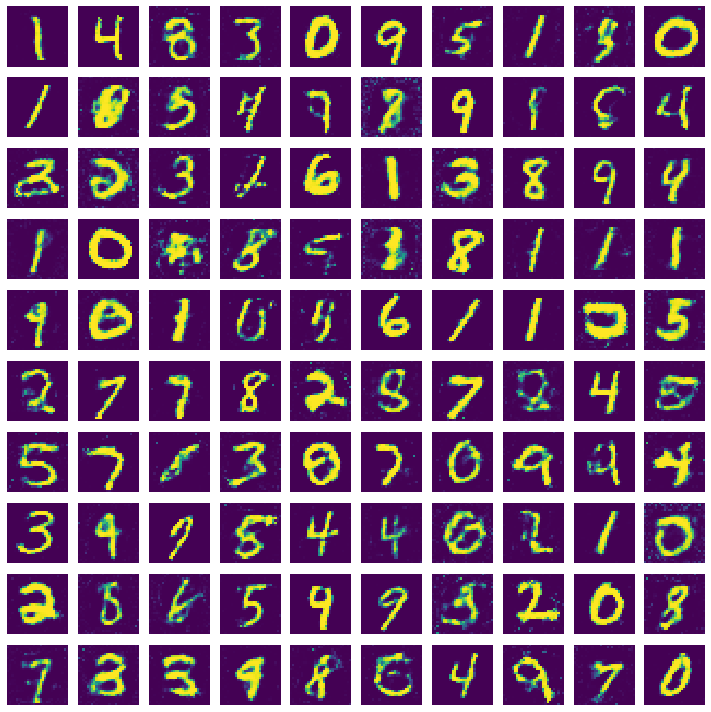

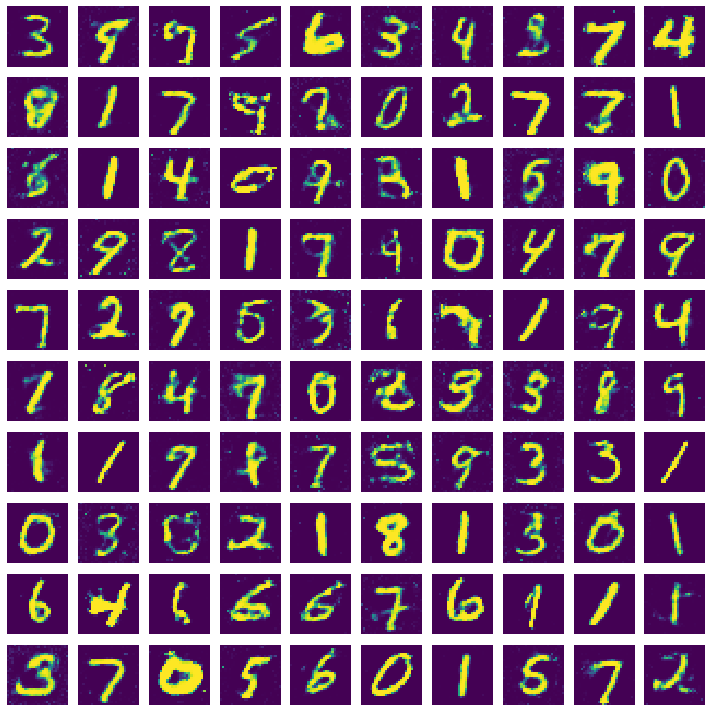

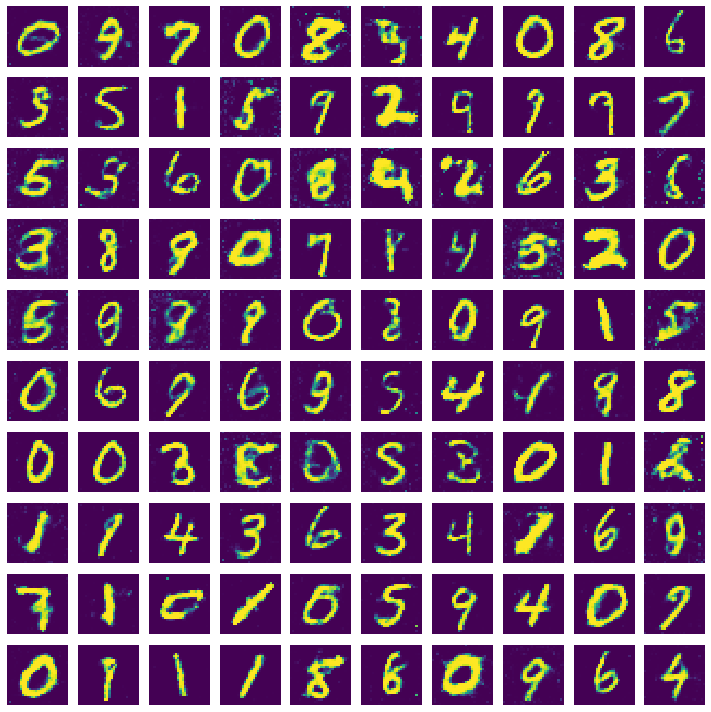

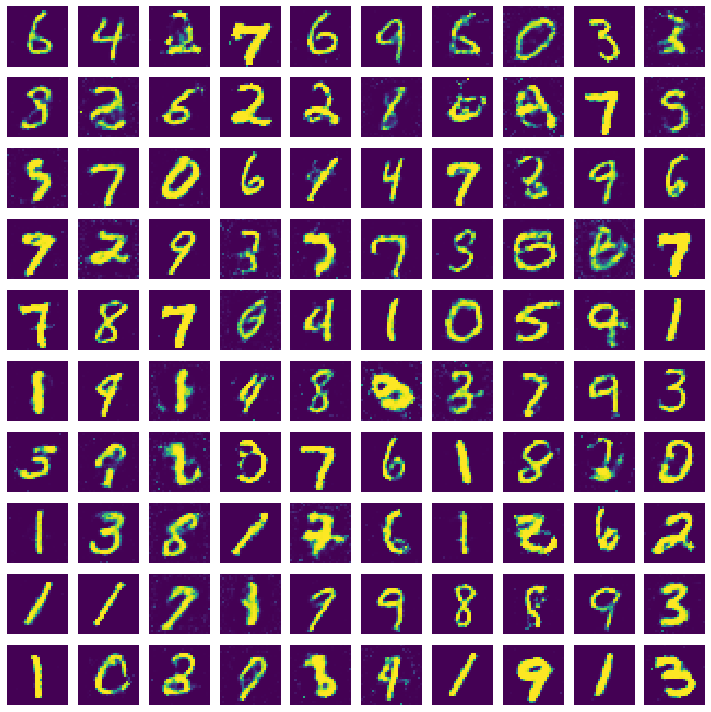

In [12]:
%%time
## epoch : 200, batch_size : 256
training(200,256)